In [8]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import colorsys
from scipy import optimize as sciopt
import os

Welcome to JupyROOT 6.18/04


In [9]:
plt.style.use("gm2")

### Initial Setup

In [31]:
files = {"1A":r.TFile("../60h/60hPosition10001.root"),
         "1B":r.TFile("../highKick/highKickPosition.root"),
         "1C":r.TFile("../9day/9dayPosition10001.root"),
         "1D":r.TFile("../endgame/EndgameData.root"),
         "2C":r.TFile("../run2C/run2CVertPos.root")}

energy_range = [1000, 2400]

### Create Histograms

In [46]:
def create_calo_hist(file, index, dataset):
    calo = file.Get("verticalPosition/clusters" + str(index)).Clone(dataset + "_calo_" + str(index))
    calo.SetAxisRange(energy_range[0], energy_range[1], "y")
    
    if( calo.GetNbinsX() == 101):
        return calo.Project3D("zx")
    else:
        calo.RebinX(99)
        if(calo.GetNbinsX() == 101):
            return calo.Project3D("zx")
        else:
            return "error in binning" + str(calo.GetNbinsX())

In [47]:
run1A_hists = []
run1B_hists = []
run1C_hists = []
run1D_hists = []
run2C_hists = []

for caloNum in range(1, 25):
    run1A_hists.append(create_calo_hist(files['1A'], caloNum, '1A'))
    run1B_hists.append(create_calo_hist(files['1B'], caloNum, '1B'))
    run1C_hists.append(create_calo_hist(files['1C'], caloNum, '1C'))
    run1D_hists.append(create_calo_hist(files['1D'], caloNum, '1D'))
    run2C_hists.append(create_calo_hist(files['2C'], caloNum, '2C'))

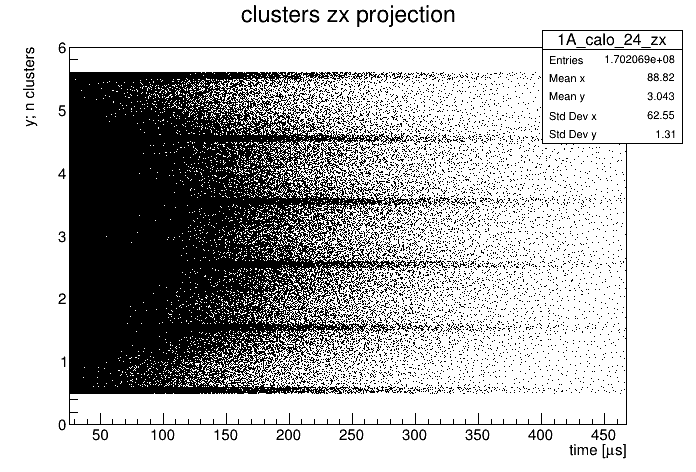

In [55]:
c = r.TCanvas()
run1A_hists[23].Draw()
c.Draw()

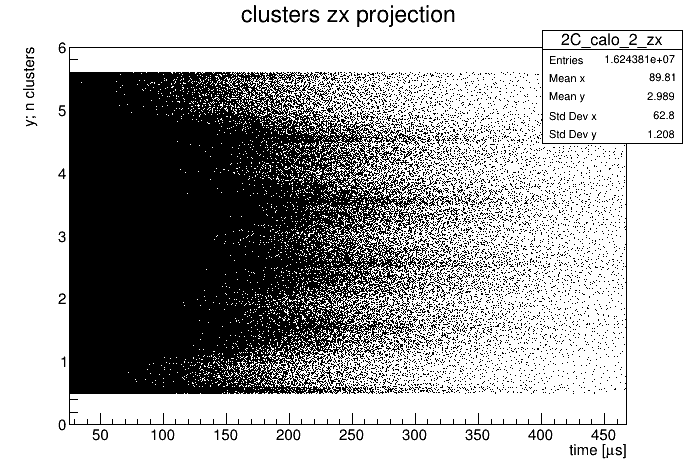

In [49]:
c = r.TCanvas()
run2C_hists[1].Draw()
c.Draw()

### Calculations Functions

In [2]:
def get_hist_stats(hist, step=1):
    """
    Performs a Gaussian fit on the distribution of Y hits for a time slice
    
    hist: [TH2D] a histogram containing the y(t) data
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    stats = []
    
    for index in range(0, hist.GetNbinsX()-step, step):
        a = dict()
        try:
            proj = hist.ProjectionY("_py", index, index+step)
            
            a['TimeBin']      = index*(hist.GetXaxis().GetXmax()/hist.GetNbinsX())
            a['HistMean']     = (proj.GetMean() - 3) * 25.2
            a['HistMeanError']= proj.GetMeanError() * 25.2
            a['HistVar']      = (proj.GetStdDev() ** 2) * (25.2 ** 2)
            a['HistVarError'] = 2 * abs(proj.GetStdDev()) * proj.GetStdDevError() * (25.2 ** 2)
                
            stats.append(a)
                
        except:
            continue

    data = pd.DataFrame(columns=['TimeBin', 'HistMean',
                                 'HistMeanError', 'HistVar',
                                 'HistVarError',])
    
    for index in range(0, len(stats)):
        data.loc[index] = stats[index]
    
    return data

In [66]:
def linear_fit(data2, mfit_lim=[30, 200], vfit_lim=[30, 200]):
    """
    Perform a linear fit on the data
    """
    data = data2.copy()
    
    # -------------------------------------------------------------------
    # Compute Mean Parameters
    # -------------------------------------------------------------------
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > mfit_lim[0]) & (data['TimeBin'] < mfit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=True, w=1/fit_data['HistMeanError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=False, cov=True, w=1/fit_data['HistMeanError'])
        
    line = linear_func(coeff[0], coeff[1], mfit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    pos_stats = [coeff[0], param_errors[0], coeff[1], param_errors[1], chisq_dof]
    
    return coeff

In [68]:
def process_hist(hist, step, mean_limits, var_limits):
    data = get_hist_stats(hist, step)
    coeff = linear_fit(data, mean_limits, var_limits)
    return coeff

### Plotting

In [ ]:
def plot_single_calo(data30, data200):
    

### Mains

In [69]:
mean_limits = [30, 200]
var_limits = [30, 200]
step = 1

calo_y_values = []

for caloNum in range(0, 24):
    y_values = pd.DataFrame(columns = ['run', 'y_at_30', 'y_at_200'])
    
    y_values['run'] = ['1A', '1B', '1C', '1D', '2C']
    
    run1A_values = process_hist(run1A_hists[caloNum], step, mean_limits, var_limits)
    run1B_values = process_hist(run1B_hists[caloNum], step, mean_limits, var_limits)
    run1C_values = process_hist(run1C_hists[caloNum], step, mean_limits, var_limits)
    run1D_values = process_hist(run1D_hists[caloNum], step, mean_limits, var_limits)
    run2C_values = process_hist(run2C_hists[caloNum], step, mean_limits, var_limits)
    
    y_values['y_at_30'] = [run1A_values[0], run1B_values[0], run1C_values[0], run1D_values[0], run2C_values[0]]
    y_values['y_at_200'] = [run1A_values[1], run1B_values[1], run1C_values[1], run1D_values[1], run2C_values[1]]
    
    calo_y_values.append(y_values)

In [70]:
print(calo_y_values[0])

  run   y_at_30  y_at_200
0  1A -0.000253  0.439387
1  1B -0.000847  0.442238
2  1C -0.001046  0.830354
3  1D -0.001088  1.027905
4  2C  0.000167 -0.139955


In [72]:
process_hist(run1A_hists[0], step, mean_limits, var_limits)

array([-2.52845474e-04,  4.39386956e-01])